# Importing Library

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load Dataset

In [3]:
# Retrieving saved dataset from github
car_data = pd.read_csv('https://raw.githubusercontent.com/Rentaku/ML_Price_Prediction/main/characteristics.csv?token=GHSAT0AAAAAACDNTPRV65Y276F3TIVSXYZ4ZD4MAPA')
car_data.head()

,ID,manufacturer,model,category,mileage,year,gear_box_type,doors,wheel,color,interior_color,vin,leather_interior,deal_type,price,customs
0,0,NISSAN,Juke,Jeep,111111111,2010,Tiptronic,4/5,Left wheel,Carnelian red,Black,JN8AF5MV2BT011450,1,For Sale,7300,0
1,1,HYUNDAI,Santa FE,Jeep,88000,2013,Tiptronic,4/5,Left wheel,Grey,Black,NaN,1,For Sale,13600,0
2,2,CHEVROLET,Cruze,Sedan,140000,2013,Tiptronic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,Price negotiable,640
3,3,TOYOTA,Prius,Sedan,71000,2013,Automatic,4/5,Left wheel,Grey,Black,NaN,1,For Sale,6100,0
4,4,SUZUKI,Grand Vitara,Jeep,155000,2008,Automatic,4/5,Left wheel,Grey,Black,JS3TD54V284130629,0,For Sale,6377,0


## Exploration 

In [4]:
print(car_data.info(), '\n') # View information on data
print(car_data.isna().sum(), '\n') # Seeing the missing value in the data
print(car_data.shape) # See data size

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80125 entries, 0 to 80124
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                80125 non-null  int64 
 1   manufacturer      80123 non-null  object
 2   model             80088 non-null  object
 3   category          80123 non-null  object
 4   mileage           80125 non-null  int64 
 5   year              80125 non-null  int64 
 6   gear_box_type     79779 non-null  object
 7   doors             78340 non-null  object
 8   wheel             80123 non-null  object
 9   color             78671 non-null  object
 10  interior_color    57910 non-null  object
 11  vin               43914 non-null  object
 12  leather_interior  80125 non-null  int64 
 13  deal_type         80125 non-null  object
 14  price             80125 non-null  object
 15  customs           80125 non-null  int64 
dtypes: int64(5), object(11)
memory usage: 9.8+ MB
None 

ID   

## Cleaning Data & Preprocessing

In [5]:
# Selecting features that are not needed in the data
car_data.drop(['ID', 'wheel','color','interior_color','vin',
               'leather_interior','customs'], axis=1, inplace=True)

# Selecting car manufactures that only exist in Indonesia
values_to_drop = ['ACURA','AUDI','VAZ','INFINITI', 'OPEL', 'LINCOLN', 'FIAT','SCION',
                  'CITROEN', 'DODGE', 'HUMMER', 'GAZ', 'VOLVO','სხვა', 'UAZ', 'ROVER',
                  'BUICK', 'SATURN', 'MOSKVICH', 'SAAB', 'FERRARI', 'BENTLEY', 'TESLA', 
                  'GMC', 'DAEWOO','MERCURY', 'MASERATI', 'GREATWALL', 'ZAZ','PONTIAC', 
                  'LANCIA', 'ALFA ROMEO', 'FOTON', 'HAVAL', 'SEAT']
car_data = car_data.drop(car_data[car_data['manufacturer'].isin(values_to_drop)].index)

In [6]:
# Clean up data on price features
car_data.drop(car_data[car_data['price'] == 'Price negotiable'].index, inplace=True)
car_data = car_data.reset_index(drop=True)

# Changing the currency exchange rate in the price feature from dollars to rupiah
car_data['price'] = car_data['price'].astype('float64')
car_data['price'] = car_data['price'] * 14529 

# Replace the value in the price feature where the vehicle status is sold, multiplied by 0.4% so that it becomes the rental price
for data in range(len(car_data)):
    if car_data.iloc[data,7]=='For Sale':
        car_data.iloc[data,8] = car_data.iloc[data,8] * 0.004

In [7]:
# Dropping invalid data
car_data = car_data.drop(car_data[car_data['price'] < 200000].index)

# Dropped the deal_type feature
car_data.drop(['deal_type'], axis=1, inplace=True)

# Retrieving car data with production year status of more than 2000
car_data = car_data[car_data['year'] >= 2000]

# Performing imputation on passenger features with missing values
car_data['doors'] = car_data['doors'].fillna(car_data['doors'].mode().iloc[0])

# Removing duplicate data
car_data.drop_duplicates(keep=False, inplace=True)
car_data.shape # Check data size

# Chenking missing value
car_data.isna().sum()

manufacturer     0
model            2
category         0
mileage          0
year             0
gear_box_type    0
doors            0
price            0
dtype: int64

In [8]:
# Drop the missing value
car_data.dropna(axis=0,inplace=True)  

# Checking data information
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19126 entries, 0 to 42492
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   manufacturer   19126 non-null  object 
 1   model          19126 non-null  object 
 2   category       19126 non-null  object 
 3   mileage        19126 non-null  int64  
 4   year           19126 non-null  int64  
 5   gear_box_type  19126 non-null  object 
 6   doors          19126 non-null  object 
 7   price          19126 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 1.3+ MB


## Outlier Detection

In [10]:
def remove_outliers(data, column):

"""     
  This function works to separate data that has different ranges, such as too 
  high or too low (outliers) in the dataframe
"""

    Q1 = np.percentile(data[column], 25)
    Q3 = np.percentile(data[column], 75)
    IQR = Q3 - Q1    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return filtered_data


In [11]:
# Use the remove_outlier functions
car_data = remove_outliers(car_data, 'price')

# Checking data shape
car_data.shape

(17906, 8)

In [12]:
# View unique data in each column of type object
print('Fitur Manufacture: \n', car_data['manufacturer'].unique(), 
      '\n', car_data['manufacturer'].unique().shape, '\n')
print('Fitur Model: \n',car_data['model'].unique(), '\n', 
      car_data['model'].unique().shape,'\n')
print('Fitur Category: \n',car_data['category'].unique(), 
      '\n', car_data['category'].unique().shape, '\n')
print('Fitur Category: \n',car_data['year'].unique(), '\n', 
      car_data['year'].unique().shape, '\n')
print('Fitur Gear Box Type: \n',car_data['gear_box_type'].unique(), 
      '\n', car_data['gear_box_type'].unique().shape)

Fitur Manufacture: 
 ['NISSAN' 'HYUNDAI' 'TOYOTA' 'SUZUKI' 'MINI' 'MERCEDES-BENZ' 'CHEVROLET'
 'BMW' 'VOLKSWAGEN' 'HONDA' 'KIA' 'LEXUS' 'SUBARU' 'MITSUBISHI' 'FORD'
 'MAZDA' 'JEEP' 'PORSCHE' 'LAND ROVER' 'CADILLAC' 'CHRYSLER' 'RENAULT'
 'JAGUAR' 'SKODA' 'SSANGYONG' 'PEUGEOT' 'ASTON MARTIN' 'MG' 'DAIHATSU'
 'ISUZU'] 
 (30,) 

Fitur Model: 
 ['Juke' 'Santa FE' 'Prius' ... 'Partner' 'Camry 55' 'E 350 CGI'] 
 (1566,) 

Fitur Category: 
 ['Jeep' 'Sedan' 'Hatchback' 'Minivan' 'Microbus' 'Goods wagon' 'Coupe'
 'Cabriolet' 'Universal' 'Pickup' 'Limousine'] 
 (11,) 

Fitur Category: 
 [2010 2013 2008 2011 2009 2004 2014 2005 2007 2000 2016 2018 2012 2017
 2019 2015 2002 2003 2006 2001 2020] 
 (21,) 

Fitur Gear Box Type: 
 ['Tiptronic' 'Automatic' 'Manual' 'Variator'] 
 (4,)


In [13]:
def one_hot_encoded(data, category):

"""
    This function separates each category for each feature that has data 
    of type categorical into a new, completely separate column
"""

    one_hot_encoded = pd.get_dummies(data[category])
    fresh_data = pd.concat([data, one_hot_encoded], axis=1)
    return fresh_data 

In [14]:
# Implement one hot encoded function
encode_data = one_hot_encoded(car_data, 'manufacturer')
encode_data = one_hot_encoded(encode_data, 'model')
encode_data = one_hot_encoded(encode_data, 'category')
encode_data = one_hot_encoded(encode_data, 'year')
clean_data = one_hot_encoded(encode_data, 'gear_box_type')
#encode_data = one_hot_encoded(encode_data, 'doors')

# Removed the original one hot encoding feature
clean_data.drop(['manufacturer', 'model', 'category', 'year', 'doors','gear_box_type'], axis=1, inplace=True)
clean_data = clean_data.reset_index(drop=True) # Reset data index
len(clean_data.columns) # Check feature length
clean_data.columns = clean_data.columns.astype(str) # Change column type to string

## Normalization

In [15]:
# Looking up the data
clean_data

,mileage,price,ASTON MARTIN,BMW,CADILLAC,CHEVROLET,CHRYSLER,DAIHATSU,FORD,HONDA,...,2015,2016,2017,2018,2019,2020,Automatic,Manual,Tiptronic,Variator
0,111111111,424246.800,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,88000,790377.600,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,71000,354507.600,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,155000,370605.732,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,92000,284768.400,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17901,152000,912421.200,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
17902,227200,366130.800,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
17903,35200,755508.000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
17904,233000,258616.200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to your data
scaler.fit(clean_data.drop(['price'],axis=1))

# Transform the data
normalized_data = scaler.transform(clean_data.drop(['price'],axis=1))
normalized_df = pd.DataFrame(normalized_data, columns=clean_data.drop(['price'],axis=1).columns)
normalized_df['price'] = clean_data['price'].astype('float64')

In [17]:
normalized_df

,mileage,ASTON MARTIN,BMW,CADILLAC,CHEVROLET,CHRYSLER,DAIHATSU,FORD,HONDA,HYUNDAI,...,2016,2017,2018,2019,2020,Automatic,Manual,Tiptronic,Variator,price
0,0.051740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,424246.800
1,0.000041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,790377.600
2,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,354507.600
3,0.000072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,370605.732
4,0.000043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,284768.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17901,0.000071,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,912421.200
17902,0.000106,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,366130.800
17903,0.000016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,755508.000
17904,0.000108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,258616.200


# Train Test Split

In [18]:
# Define variabel for X and y
X = normalized_df.drop(['price'],axis=1)
y = normalized_df['price']

# Splitting the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.005 , random_state = 42)

# Cheking the data shapes
print("X_train shape:", X_train.shape) 
print("X_test shape:", X_test.shape) 
print("y_train shape:", y_train.shape) 
print("y_test shape:", y_test.shape)

X_train shape: (17816, 1633)
X_test shape: (90, 1633)
y_train shape: (17816,)
y_test shape: (90,)


print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape) 
print("y_train shape:", y_train.shape)
print("X_test shape:", y_test.shape)

## Modelling

In [19]:
# Creating new metric for measure model performances
class RSquared(tf.keras.metrics.Metric):
    def __init__(self, name='r_squared', **kwargs):
        super(RSquared, self).__init__(name=name, **kwargs)
        self.total_residual = self.add_weight(name='total_residual', initializer='zeros')
        self.total_total = self.add_weight(name='total_total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
        total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
        self.total_residual.assign_add(residual)
        self.total_total.assign_add(total)

    def result(self):
        r2_score = 1 - tf.math.divide_no_nan(self.total_residual, self.total_total)
        return r2_score

    def reset_states(self):
        self.total_residual.assign(0.0)
        self.total_total.assign(0.0)

In [22]:
# Creating the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1028, activation='relu', input_shape=(1633,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])

# Define Callbacks
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch/20))

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
             loss= 'mean_absolute_error',
             metrics= [RSquared()])

# Create history and train the model
history = model.fit(X_train,
          y_train,
          epochs=100,
          callbacks=[lr_schedule],
          validation_data=(X_test,y_test)
         )

Epoch 1/100
557/557 [==============================] - 6s 5ms/step - loss: 423618.6250 - r_squared: -4.8786 - val_loss: 396913.1562 - val_r_squared: -5.3780 - lr: 1.0000e-05
Epoch 2/100
 14/557 [..............................] - ETA: 2s - loss: 428500.1875 - r_squared: -4.7448

/usr/local/lib/python3.10/dist-packages/keras/engine/training.py:2448: UserWarning: Metric RSquared implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


557/557 [==============================] - 2s 4ms/step - loss: 422035.5000 - r_squared: -4.8283 - val_loss: 390801.0625 - val_r_squared: -5.2143 - lr: 1.1220e-05
Epoch 3/100
557/557 [==============================] - 2s 4ms/step - loss: 384650.5625 - r_squared: -4.0231 - val_loss: 289967.6875 - val_r_squared: -2.8843 - lr: 1.2589e-05
Epoch 4/100
557/557 [==============================] - 2s 4ms/step - loss: 190566.4844 - r_squared: -0.8742 - val_loss: 126318.5703 - val_r_squared: -0.0685 - lr: 1.4125e-05
Epoch 5/100
557/557 [==============================] - 3s 5ms/step - loss: 138537.3125 - r_squared: -0.0387 - val_loss: 123013.5234 - val_r_squared: 0.0338 - lr: 1.5849e-05
Epoch 6/100
557/557 [==============================] - 3s 5ms/step - loss: 131363.3281 - r_squared: 0.0791 - val_loss: 119557.2656 - val_r_squared: 0.0852 - lr: 1.7783e-05
Epoch 7/100
557/557 [==============================] - 2s 4ms/step - loss: 125163.8828 - r_squared: 0.1650 - val_loss: 116277.2188 - val_r_square

(1e-05, 1.0, 0.0, 600000.0)

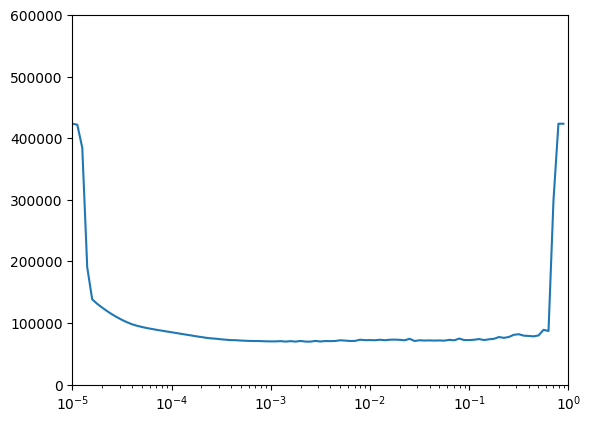

In [23]:
# Looking up learning rate performance
lrs = 1e-5 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history['loss'])  
plt.axis([1e-5, 1e-0, 0, 600000])

In [24]:
# Creating the new architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1028, activation='relu', input_shape=(1633,), kernel_regularizer=tf.keras.regularizers.l1(0.05)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense(1, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))
])

# Compiling the model again
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
             loss= 'mean_absolute_error',
             metrics= [RSquared()])

# Creating new history and train the model
history = model.fit(X_train,
          y_train,
          epochs=100,
          validation_data=(X_test,y_test)
         )

Epoch 1/100
557/557 [==============================] - 6s 5ms/step - loss: 150305.9062 - r_squared: -0.3366 - val_loss: 95901.9297 - val_r_squared: 0.4304
Epoch 2/100
  1/557 [..............................] - ETA: 4s - loss: 94247.4453 - r_squared: 0.5193

/usr/local/lib/python3.10/dist-packages/keras/engine/training.py:2448: UserWarning: Metric RSquared implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


557/557 [==============================] - 3s 5ms/step - loss: 90513.5859 - r_squared: 0.5602 - val_loss: 84809.8906 - val_r_squared: 0.5075
Epoch 3/100
557/557 [==============================] - 3s 6ms/step - loss: 84758.4375 - r_squared: 0.5977 - val_loss: 86369.7578 - val_r_squared: 0.5116
Epoch 4/100
557/557 [==============================] - 3s 5ms/step - loss: 82543.0625 - r_squared: 0.6127 - val_loss: 88673.3906 - val_r_squared: 0.5311
Epoch 5/100
557/557 [==============================] - 3s 5ms/step - loss: 80751.9453 - r_squared: 0.6251 - val_loss: 86032.8672 - val_r_squared: 0.5345
Epoch 6/100
557/557 [==============================] - 3s 5ms/step - loss: 78718.3203 - r_squared: 0.6385 - val_loss: 85767.4922 - val_r_squared: 0.5543
Epoch 7/100
557/557 [==============================] - 3s 5ms/step - loss: 77933.1875 - r_squared: 0.6477 - val_loss: 90917.8359 - val_r_squared: 0.5154
Epoch 8/100
557/557 [==============================] - 3s 5ms/step - loss: 77437.2969 - r_squa

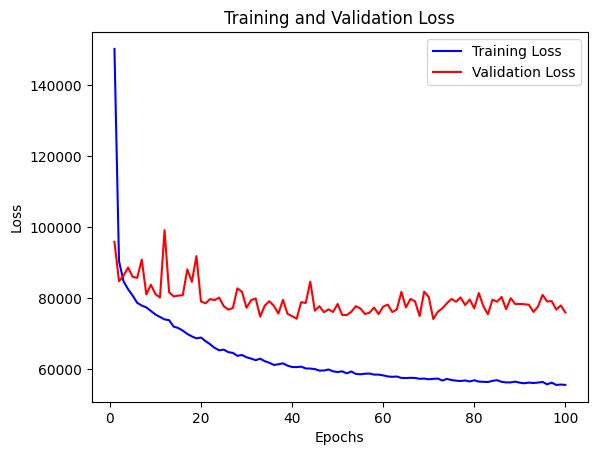

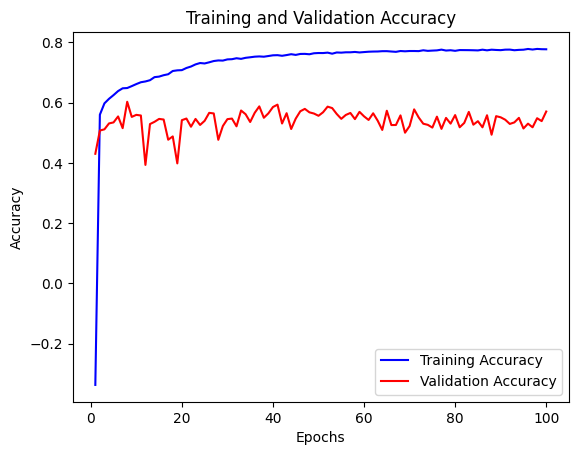

In [25]:
# Define error metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['r_squared']
val_acc = history.history['val_r_squared']

# Visualize training loss and validation loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize training accuracy and validation accuracy
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
normalized_df

,mileage,ASTON MARTIN,BMW,CADILLAC,CHEVROLET,CHRYSLER,DAIHATSU,FORD,HONDA,HYUNDAI,...,2016,2017,2018,2019,2020,Automatic,Manual,Tiptronic,Variator,price
0,0.051740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,424246.800
1,0.000041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,790377.600
2,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,354507.600
3,0.000072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,370605.732
4,0.000043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,284768.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17901,0.000071,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,912421.200
17902,0.000106,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,366130.800
17903,0.000016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,755508.000
17904,0.000108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,258616.200


# Test Model

In [ ]:
# Creating an variable to keep input values
input_value0 = input("Masukkan nama mileage: ")
input_value1 = input("Masukkan nama manufaktur: ")
input_value2 = input("Masukkan nama model: ")
input_value3 = input("Masukkan nama kategori: ")
input_value4 = input("Masukkan nama Tahun: ")
input_value5 = input("Masukkan nama gear_box: ")

# separate features by group
column_names1 = normalized_df.columns[1:31]  # Nama-nama kolom
column_names2 = normalized_df.columns[31:1597]
column_names3 = normalized_df.columns[1597:1608]
column_names4 = normalized_df.columns[1608:1629]
column_names5 = normalized_df.columns[1629:1633]

# create a list based on the input values for each feature group
result_list = [input_value0] + \
              [1 if col == input_value1 else 0 for col in column_names1] + \
              [1 if col == input_value2 else 0 for col in column_names2] + \
              [1 if col == input_value3 else 0 for col in column_names3] + \
              [1 if col == input_value4 else 0 for col in column_names4] + \
              [1 if col == input_value5 else 0 for col in column_names5]

# Transforming list of data
data_predict = scaler.transform([result_list])

# Predicting the data using models
predictions = model.predict(data_predict)
print(predictions) # print output of predictions

# Convert to TFLite

In [27]:
export_dir = "../saved_model"
tf.saved_model.save(model, export_dir)


converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)


8731648

# Convert to h5 and TFJS

In [28]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
xar

In [29]:
import time
saved_model_path = "./Untitled Folder/{}.h5".format(int(time.time()))

model.save(saved_model_path)
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

2023-06-04 10:13:59.966637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: TensorFlow.js model converters.
       [-h]
       [--input_format {tf_frozen_model,keras,tfjs_layers_model,tf_saved_model,keras_saved_model,tf_hub}]
       [--output_format {tfjs_graph_model,keras,tfjs_layers_model,keras_saved_model}]
       [--signature_name SIGNATURE_NAME]
       [--saved_model_tags SAVED_MODEL_TAGS]
       [--quantize_float16 [QUANTIZE_FLOAT16]]
       [--quantize_uint8 [QUANTIZE_UINT8]]
       [--quantize_uint16 [QUANTIZE_UINT16]]
       [--quantization_bytes {1,2}]
       [--split_weights_by_layer]
       [--version]
       [--skip_op_check]
       [--strip_debug_ops STRIP_DEBUG_OPS]
       [--use_structured_outputs_names USE_STRUCTURED_OUTPUTS_NAMES]
       [--weight_shard_size_bytes WEIGHT_SHARD_SIZE_BYTES]
       [--output_node_names OUTPUT_NODE_NAMES]
       [--control_flow_v2 CONTROL_FLOW_V2]
       [--experiments EXPERIMENTS]
  